##Тестовое "Билайн"##

Описание таблицы:  

organization_id - Регион (РК),  
sales_order - Номер заказа (2051 - сайт, 2061 - приложение),  
date_create - Дата и время создания заказа,  
status - Статус заказа (0 - Выдан, остальные - Отменен),  
code - Код товара,  
client_id - Код клиента,  
tvz_id - Код точки выдачи заказа,  
cost_price - Себестоимость,  
price_b2b_gross - B2B цена,  
price_b2c_gross - B2C цена,  
quantity - Количество товара в заказе.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel('beeline.xlsx', sheet_name='Таблица t_orders')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27704 entries, 0 to 27703
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   organization_id  27704 non-null  int64  
 1   sales_order      27704 non-null  int64  
 2   date_create      27704 non-null  object 
 3   status           27704 non-null  int64  
 4   code             27704 non-null  int64  
 5   client_id        27704 non-null  int64  
 6   tvz_id           27704 non-null  int64  
 7   cost_price       27704 non-null  float64
 8   price_b2b_gross  27704 non-null  float64
 9   price_b2c_gross  27704 non-null  float64
 10  quantity         27704 non-null  int64  
dtypes: float64(3), int64(7), object(1)
memory usage: 2.3+ MB


In [4]:
df.head()

,organization_id,sales_order,date_create,status,code,client_id,tvz_id,cost_price,price_b2b_gross,price_b2c_gross,quantity
0,13,2051029251,2022-08-02T16:51:03.023,0,65106,21276,7342,20059.865943,0.0,0.0,1
1,13,2051030871,2022-08-12T08:50:06.031,2,65106,20793,7011,20059.865943,0.0,0.0,1
2,13,2051030897,2022-08-12T10:18:02.624,3,65106,20793,7011,20059.865943,0.0,0.0,1
3,13,2051030944,2022-08-12T13:03:03.590,0,65106,20793,7012,20059.865943,0.0,0.0,1
4,13,2051020015,2022-06-17T16:58:02.885,0,65106,495,7104,20059.865943,0.0,0.0,1


###Задание 1###
Построить динамику маржи по неделям. Предоставить запрос в SQL, нарисовать диаграму, указать лучшую неделю и сумму маржи.


Напишем запрос в SQL:

```sql
with calculate as (
  select
    date_trunc('week', date_create::date) as week,
    (price_b2c_gross - cost_price) * quantity as margin
  from t_orders
  where status = 0 and price_b2c_gross > 0
)
select
  week,
  sum(margin) as margin
from calculate
group by week
order by margin desc
limit 1
```

Так как нет возможности подключиться к базе, то получим данный резульатат с помощью Python:

In [5]:
# отфильтруем по статусу заказа
df = df[(df['status']==0) & (df['price_b2c_gross']>0)]

# создадим столбец с неделей
df['week'] = pd.to_datetime(df['date_create']).dt.to_period('W').dt.start_time

# вычислим маржу
df['margin'] = round((df['price_b2c_gross']-df['cost_price'])*df['quantity'],2)

<ipython-input-5-617f332e8305>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['week'] = pd.to_datetime(df['date_create']).dt.to_period('W').dt.start_time
<ipython-input-5-617f332e8305>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['margin'] = round((df['price_b2c_gross']-df['cost_price'])*df['quantity'],2)


In [6]:
margin = df.groupby('week', as_index=False)['margin'].sum()
top = margin.sort_values('margin', ascending=False).iloc[0]
print(f'Лучшая неделя {str(top.iloc[0])[:10]} с суммой маржи {top.iloc[1]} руб.')

Лучшая неделя 2022-07-25 с суммой маржи 1547577.43 руб.


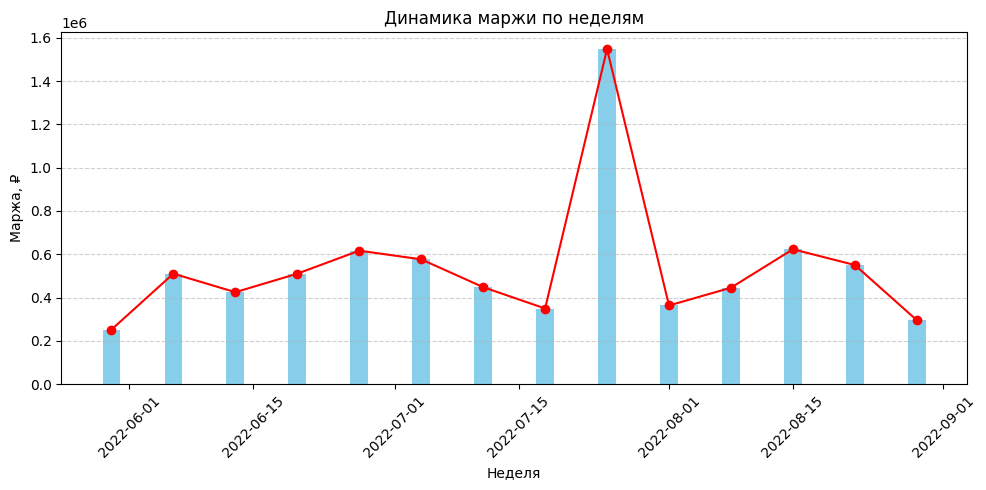

In [7]:
plt.figure(figsize=(10,5))
plt.plot(margin['week'],margin['margin'],marker='o', color='red')
plt.bar(margin['week'],margin['margin'], color='skyblue', width=2)
plt.title('Динамика маржи по неделям')
plt.xlabel('Неделя')
plt.ylabel('Маржа, ₽')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

###Задание 2###
Рассчитать маржу в рублях и % по всей компании за август в разрезе Сайта и Приложения. Вывести поля: Сайт, Приложение Строки: Маржа руб., Маржа %. Предоставить запрос в SQL.


SQL запрос:

```sql
with august_orders as (
  select
    case
     when sales_order::varchar like '2051%' then "сайт"
     when sales_order::varchar like '2061%' then "приложение"
    end as source
    price_b2c_gross * quantity as revenue
    (price_b2c_gross - cost_price) * quantity as margin
  from t_orders
  where status = 0 and price_b2c_gross > 0
  and date_create::date between '2022-08-01' and '2022-08-31'
),
agg as (
	select
		source,
		sum(margin) as margin,
		sum(revenue) as revenue
	from march_orders
	group by source
)
select
  'Маржа, ₽' as "Метрика",
  sum(case when source = 'сайт' then margin end) as "Сайт",
  sum(case when source = 'приложение' then margin end) as "Приложение"
from agg
union all
select
  'Маржа, %' as "Метрика",
  round(100.0 * sum(case when source = 'сайт' then margin end) /
  sum(case when source = 'сайт' then revenue end), 2) as "Сайт",
  round(100.0 * sum(case when source = 'приложение' then margin end) /
  sum(case when source = 'приложение' then revenue end), 2) as "Приложение"
from agg
```

Реализуем задачу с помощью Python.

In [8]:
# рассчитаем выручку
df['revenue'] = df['price_b2c_gross'] * df['quantity']

# оставляем заказы только за август
august = df[(pd.to_datetime(df['date_create']).dt.strftime('%Y-%m-%d') >= '2022-08-01')
& (pd.to_datetime(df['date_create']).dt.strftime('%Y-%m-%d') <= '2022-08-31')]

# в соответствии с номером заказа определяем канал покупки
def switch(x):
  if str(x)[:4]=='2051':
    return 'сайт'
  if str(x)[:4]=='2061':
    return 'приложение'

august['channel'] = august['sales_order'].apply(switch)
#august['channel'] = august['sales_order'].apply(lambda x: 'сайт' if str(x)[:4]=='2051' else 'приложение')

<ipython-input-8-ab00e1f848fc>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  august['channel'] = august['sales_order'].apply(switch)


In [13]:
# группируем данные
august_margin = august.groupby('channel').agg({'margin':'sum','revenue':'sum'}).rename(columns={'margin':'margin, ₽'})

# рассчитываем маржу в %
august_margin['margin, %'] = round(100 * august_margin['margin, ₽']/august_margin['revenue'], 2)

# формируем итоговую таблицу
final_table = august_margin.drop('revenue', axis=1).transpose()
final_table

channel,приложение,сайт
"margin, ₽",24305.70,2254628.61
"margin, %",22.59,23.84


###Задание 3###
По результатам опроса было выявлено, что 70% клиентов предпочитают списывать бонусы, а 80% - использовать промокоды. Найдите % клиентов, которые любят как списывать бонусы, так и использовать промокоды.

Используя диаграмму Эйлера-Венна:  
В левом множестве — 70%, в правом множестве — 80%. Суммарно (всё левое + всё правое) — 100%. Значит, пересечение учтено дважды: и в левых, и в правых 70% и 80% включено одно и то же общее подмножество.  
Чтобы найти пересечение, применим формулу:
|A  B| = |A| + |B| – |A ∩ B|  
Подставим:  
100% = 70% + 80% – x x = 150% – 100% = 50%   
Ответ:   
50% — это доля на пересечении. Потому что общее множество (100%) включает в себя:
70% из A (включая тех, кто в обоих)
80% из B (включая тех же)
чтобы не считать пересечение дважды, мы его вычитаем.
